In [1]:
!pip install chess
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, FourPeaks, FlipFlopGenerator, KnapsackGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner
from A2_helpers.Four_peaks_helpers import Runner_overSeeds
import pandas as pd


# switch off the chatter
logging.basicConfig(level=logging.WARNING)

# fitness funcions list
#https://mlrose.readthedocs.io/en/stable/source/fitness.html#fitness

# about the mlrose setup
#https://mlrose.readthedocs.io/en/stable/source/tutorial1.html

# algos
# https://mlrose.readthedocs.io/en/stable/source/algorithms.html#algs

C:\Users\WarrenKushner\AppData\Local\Temp\ipykernel_56728\426872300.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML # for some notebook formatting.


In [2]:
from mlrose_hiive.opt_probs.discrete_opt import DiscreteOpt
t_pct = 0.2
fitness = FourPeaks(t_pct=t_pct)
length = 10
problem = DiscreteOpt(length=length, fitness_fn=fitness,  maximize = True, max_val = 2)

maximum_expected = length - (t_pct* length + 1) +length
print(f"maximum_expected: {maximum_expected}")


maximum_expected: 17.0


In [3]:
import pandas as pd
import mlrose_hiive
schedule = mlrose_hiive.ExpDecay()
init_state = length //2 * [0,1]



# SARunner(problem=problem,
#                 experiment_name=None,
#                 output_directory='./', # note: specify an output directory to have results saved to disk
#                 seed=seed,
#                 iteration_list=2 ** np.arange(11),
#                 max_attempts=10,
#                 temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0]
        # )

seeds = [1, 2, 3, 4, 5,10]
df_run_stats_total = []
df_run_curves_total = []
for s in seeds:
    # Solve problem using simulated annealing
    mlrose_hiive.simulated_annealing(problem, schedule = schedule,
                                                        max_attempts = 1000, max_iters = 100,
                                                        init_state = init_state, random_state = s)

    # print(best_state)

    # create a runner class and solve the problem
    sa = SARunner(problem=problem,
                experiment_name='4peaks_sa',
                output_directory=None, # note: specify an output directory to have results saved to disk
                seed=s,
                iteration_list=2 ** np.arange(11),
                max_attempts=10,
                temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
                decay_list=[mlrose_hiive.GeomDecay, mlrose_hiive.ExpDecay],)

    # the two data frames will contain the results
    df_run_stats, df_run_curves = sa.run()
    df_run_stats["seed"] = s
    df_run_curves["seed"] = s
    df_run_stats_total.append(df_run_stats)
    df_run_curves_total.append(df_run_curves)
    
    # print(best_fitness)
    # 2.0

# concat the dataframes
df_run_stats_total = pd.concat(df_run_stats_total)
df_run_curves_total = pd.concat(df_run_curves_total)

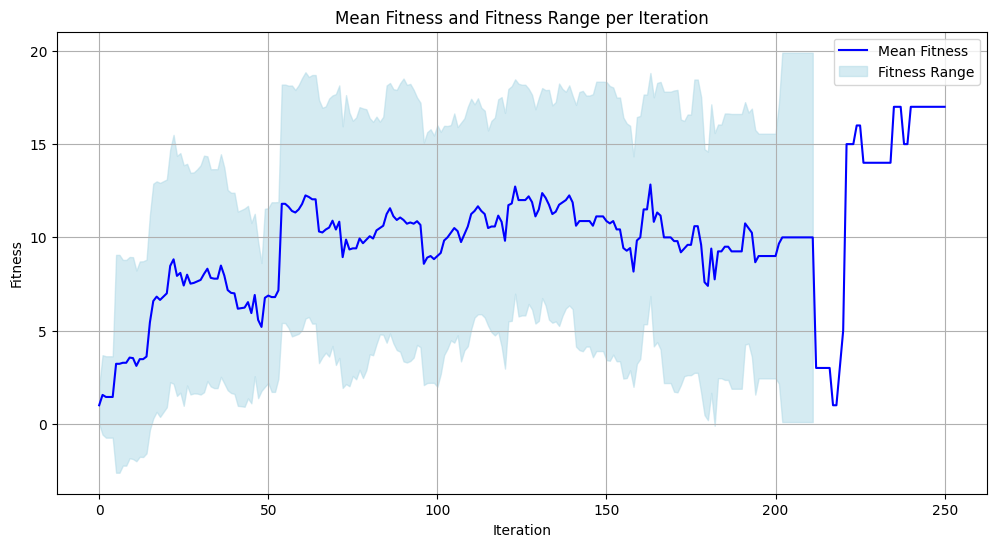

In [4]:
# plot iteration vs fitness and iteration vs time

# get the mean and std fitness per iteration
df_grouped = df_run_curves_total[['Iteration', 'Fitness']].groupby('Iteration')
# Group by iteration and calculate mean, max, and min fitness
grouped = df_run_curves_total.groupby('Iteration')
mean_fitness = grouped['Fitness'].mean()
max_fitness = mean_fitness + grouped['Fitness'].std()
min_fitness = mean_fitness - grouped['Fitness'].std()

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(mean_fitness.index, mean_fitness, label='Mean Fitness', color='blue')
plt.fill_between(mean_fitness.index, min_fitness, max_fitness, color='lightblue', alpha=0.5, label='Fitness Range')

plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Mean Fitness and Fitness Range per Iteration')
plt.legend()
plt.grid(True)
plt.show()


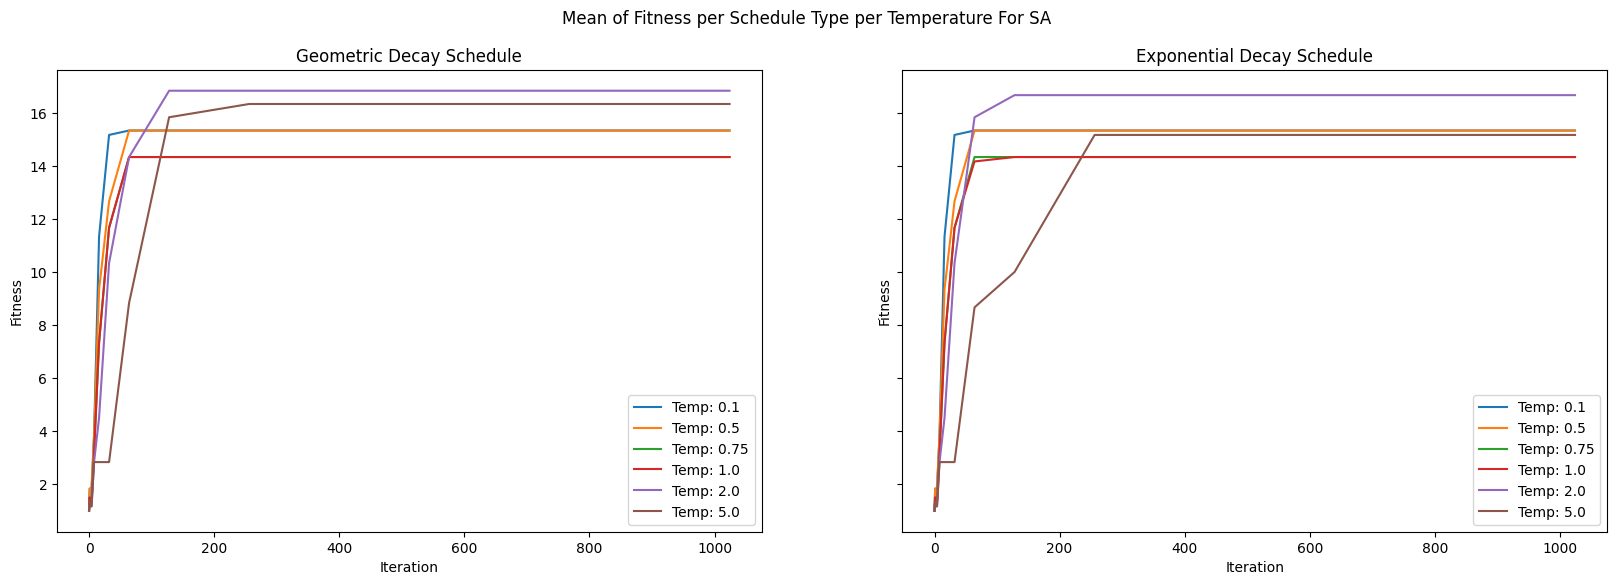

In [5]:
# Define unique temperatures and schedule types
temperatures = df_run_stats['schedule_init_temp'].unique()
schedule_types = df_run_stats['schedule_type'].unique()

#  0.5, 0.75, 1.0, 2.0, 5.0]
# Plotting mean and variance for each schedule type per temperature
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
df_run_stats_total
# Plot for geometric decay schedule
for temperature in temperatures:
    filtered_df = df_run_stats_total[(df_run_stats_total['schedule_type'] == 'geometric') & 
                               (df_run_stats_total['schedule_init_temp'] == temperature)]
    
    if not filtered_df.empty:
        iterations = filtered_df['Iteration'].unique()
        mean_fitness = filtered_df.groupby('Iteration')['Fitness'].mean()
        std_fitness = filtered_df.groupby('Iteration')['Fitness'].std()
        # print( std_fitness, mean_fitness)
        ax1.plot(iterations, mean_fitness, label=f"Temp: {temperature}")
        # ax1.fill_between(iterations, mean_fitness - std_fitness, 
                        # mean_fitness + std_fitness, alpha=0.2)

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fitness')
ax1.set_title('Geometric Decay Schedule')
ax1.legend()

# Plot for exponential decay schedule
for temperature in temperatures:
    filtered_df = df_run_stats_total[(df_run_stats_total['schedule_type'] == 'exponential') & 
                               (df_run_stats_total['schedule_init_temp'] == temperature)]
    
    if not filtered_df.empty:
        iterations = filtered_df['Iteration'].unique()
        mean_fitness = filtered_df.groupby('Iteration')['Fitness'].mean()
        std_fitness = filtered_df.groupby('Iteration')['Fitness'].std()
        
        ax2.plot(iterations, mean_fitness, label=f"Temp: {temperature}")
        # ax2.fill_between(iterations, mean_fitness - std_fitness, 
        #                 mean_fitness + std_fitness, alpha=0.2)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Fitness')
ax2.set_title('Exponential Decay Schedule')
ax2.legend()

plt.suptitle('Mean of Fitness per Schedule Type per Temperature For SA')
plt.show()



In [6]:
from A2_helpers import Four_peaks_helpers
 


problems = Four_peaks_helpers.genaerate_problems_over_size(length = [ 10, 20, 40, 80 , 160 ])

maximum_expected: 17.0 for size 10
maximum_expected: 35.0 for size 20
maximum_expected: 71.0 for size 40
maximum_expected: 143.0 for size 80
maximum_expected: 287.0 for size 160


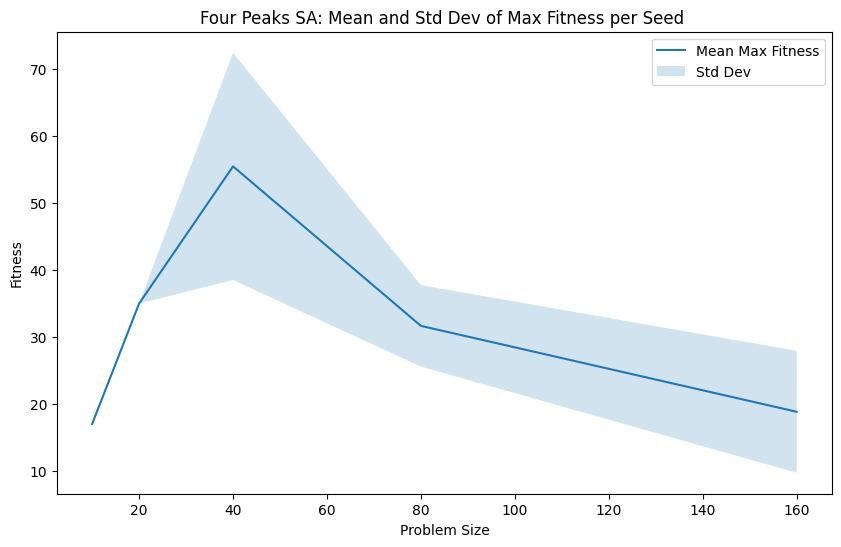

[     Iteration  Fitness  FEvals      Time                           State  \
 0            0      2.0       0  0.000221  [1, 1, 0, 0, 1, 1, 1, 1, 1, 0]   
 1            1      2.0       1  0.002078  [1, 1, 0, 0, 1, 1, 1, 1, 1, 0]   
 2            2      2.0       3  0.006594  [1, 1, 0, 0, 1, 1, 1, 0, 1, 0]   
 3            4      2.0       7  0.008977  [1, 1, 0, 0, 0, 1, 0, 0, 1, 0]   
 4            8      3.0      14  0.011377  [1, 1, 1, 0, 1, 1, 0, 1, 1, 0]   
 ..         ...      ...     ...       ...                             ...   
 139         64      0.0     126  0.052349  [0, 1, 0, 1, 1, 1, 1, 1, 0, 1]   
 140        128     17.0     226  0.062647  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]   
 141        256     17.0     364  0.077736  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]   
 142        512     17.0     620  0.116530  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]   
 143       1024     17.0     850  0.163392  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]   
 
     schedule_type  schedule_init_temp  schedule_exp_const  sc

<Figure size 640x480 with 0 Axes>

In [7]:
from A2_helpers.Four_peaks_helpers import Runner_overSeeds

"""
For all temperatures and decay schedules, run the SA algorithm for the 4-peaks problem for problem sizes of 10, 20, 40, 80, and 160
We find the mean maximum per seed (i.e per run across all other parameters and iteratsions to cover the optimum this algorithm can do on this problem)
"""
#     sa = SARunner(problem=problem,
#                 experiment_name='4peaks_sa',
#                 output_directory=None, # note: specify an output directory to have results saved to disk
#                 seed=s,
#                 iteration_list=2 ** np.arange(11),
#                 max_attempts=10,
#                 temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
# 
# decay_list=[mlrose_hiive.GeomDecay, mlrose_hiive.ExpDecay],)
kwargs = { "iteration_list":2 ** np.arange(11), "temperature_list": [0.1, 0.5, 0.75, 1.0, 2.0, 5.0], "decay_list":[mlrose_hiive.ExpDecay, mlrose_hiive.GeomDecay], "max_attempts":500,  "experiment_name": "SA_runner"} 

sizes = []
mean_fitness_per_size = []
std_fitness_per_size = []
df_run_stats_total_all_problem_sizes_sa = []
df_run_curves_total_all_problem_sizes_sa = []
for size,p in problems:
    
     df_run_stats_total, df_run_curves_total = Runner_overSeeds( 
                     problem = p, 
                     seeds = [1, 2, 3, 4, 5,10], 
                     **kwargs
                     )
     df_run_stats_total["problem_size"] = size
     df_run_stats_total_all_problem_sizes_sa.append(df_run_stats_total)
     df_run_curves_total_all_problem_sizes_sa.append(df_run_curves_total)
     
          # Find the mean max fitness per seed
     max_fitness_per_seed = df_run_curves_total.groupby('seed')['Fitness'].max()
     mean_fitness = max_fitness_per_seed.mean()
     std_fitness = max_fitness_per_seed.std()
     
     mean_fitness_per_size.append(mean_fitness)
     std_fitness_per_size.append(std_fitness)
     sizes.append(size)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, mean_fitness_per_size, label='Mean Max Fitness')
ax.fill_between(sizes, 
                np.array(mean_fitness_per_size) - np.array(std_fitness_per_size), 
                np.array(mean_fitness_per_size) + np.array(std_fitness_per_size), 
                alpha=0.2, label='Std Dev')

ax.set_xlabel('Problem Size')
ax.set_ylabel('Fitness')
ax.set_title('Four Peaks SA: Mean and Std Dev of Max Fitness per Seed ')
ax.legend()
plt.show()
plt.savefig("Four_peaks_SA_mean_max_fitness_per_seed.png")

df_run_stats_total_all_problem_sizes_sa



problems

In [8]:
## SA convert to dataframes and save to csv
if df_run_stats_total_all_problem_sizes_sa and df_run_curves_total_all_problem_sizes_sa:
    df_run_stats_total_all_problem_sizes_sa = pd.concat(df_run_stats_total_all_problem_sizes_sa)
    df_run_curves_total_all_problem_sizes_sa = pd.concat(df_run_curves_total_all_problem_sizes_sa)

    df_run_stats_total_all_problem_sizes_sa.to_csv("RunData/4peaks/4peaks_df_run_stats_total_all_problem_sizes_sa.csv")
    df_run_curves_total_all_problem_sizes_sa.to_csv("RunData/4peaks/4peaks_df_run_curves_total_all_problem_sizes_sa.csv")

## GA Runner

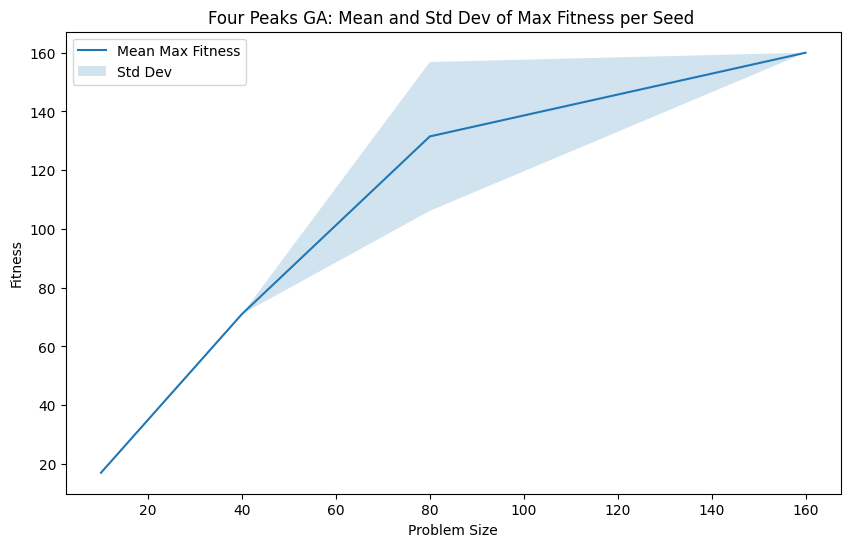

<Figure size 640x480 with 0 Axes>

In [9]:
    # create a runner class and solve the problem
kwargs = { "iteration_list":2 ** np.arange(11), "population_sizes": [5,10,30,50,70], "mutation_rates":[0.05,0.1, 0.2, 0.5,0.75], "experiment_name": "GA_runner"} 

sizes = []
mean_fitness_per_size = []
std_fitness_per_size = []
df_run_stats_total_all_problem_sizes_ga = []
df_run_curves_total_all_problem_sizes_ga = []
for size,p in problems:
    
     df_run_stats_total, df_run_curves_total = Runner_overSeeds( 
                     problem = p, 
                     seeds = [1, 2, 3, 4, 5,10], 
                     runner_algorthm= mlrose_hiive.GARunner,
                     **kwargs
                     )
     df_run_stats_total["problem_size"] = size
     df_run_stats_total_all_problem_sizes_ga.append(df_run_stats_total)
     df_run_curves_total_all_problem_sizes_ga.append(df_run_curves_total)
     
          # Find the mean max fitness per seed
     max_fitness_per_seed = df_run_curves_total.groupby('seed')['Fitness'].max()
     mean_fitness = max_fitness_per_seed.mean()
     std_fitness = max_fitness_per_seed.std()
     
     mean_fitness_per_size.append(mean_fitness)
     std_fitness_per_size.append(std_fitness)
     sizes.append(size)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, mean_fitness_per_size, label='Mean Max Fitness')
ax.fill_between(sizes, 
                np.array(mean_fitness_per_size) - np.array(std_fitness_per_size), 
                np.array(mean_fitness_per_size) + np.array(std_fitness_per_size), 
                alpha=0.2, label='Std Dev')

ax.set_xlabel('Problem Size')
ax.set_ylabel('Fitness')
ax.set_title('Four Peaks GA: Mean and Std Dev of Max Fitness per Seed ')
ax.legend()
plt.show()
plt.savefig("Four_peaks_GA_mean_max_fitness_per_seed.png")


In [10]:
# convert the above to dataframes and save to csv
if df_run_stats_total_all_problem_sizes_ga and df_run_curves_total_all_problem_sizes_ga:
    df_run_stats_total_all_problem_sizes_ga = pd.concat(df_run_stats_total_all_problem_sizes_ga)
    df_run_curves_total_all_problem_sizes_ga = pd.concat(df_run_curves_total_all_problem_sizes_ga)

    df_run_stats_total_all_problem_sizes_ga.to_csv("RunData/4peaks/4peaks_df_run_stats_total_all_problem_sizes_ga.csv")
    df_run_curves_total_all_problem_sizes_ga.to_csv("RunData/4peaks/4peaks_df_run_curves_total_all_problem_sizes_ga.csv")

## RHC Runner

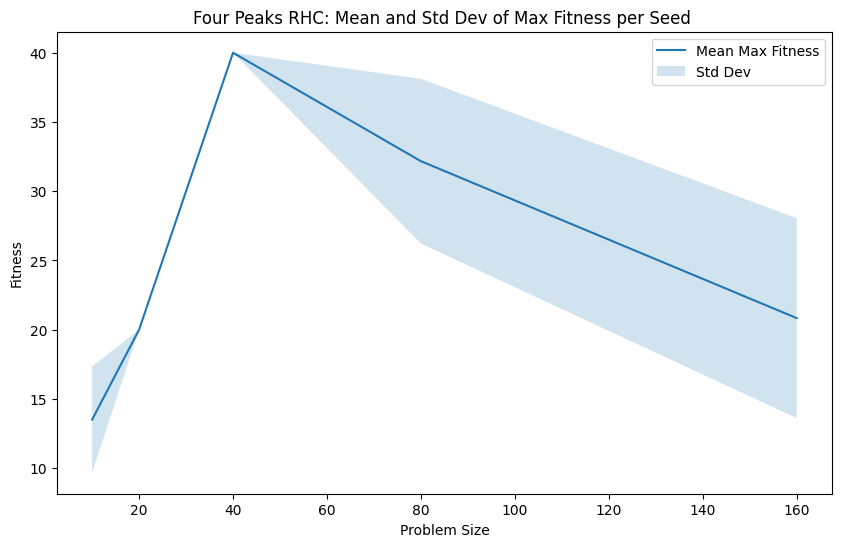

In [11]:
# import runnover over seeds
                 
                 
    # create a runner class and solve the problem
kwargs = { "iteration_list":2 ** np.arange(11), "restart_list": [1],  "experiment_name": "RHC_runner"} 

sizes = []
mean_fitness_per_size = []
std_fitness_per_size = []
df_run_stats_total_all_problem_sizes_rhc = []
df_run_curves_total_all_problem_sizes_rhc = []
for size,p in problems:
    
     df_run_stats_total, df_run_curves_total = Runner_overSeeds( 
                     problem = p, 
                     seeds = [1, 2, 3, 4, 5,10], 
                     runner_algorthm= mlrose_hiive.RHCRunner,
                     **kwargs
                     )
     df_run_stats_total["problem_size"] = size
     df_run_stats_total_all_problem_sizes_rhc.append(df_run_stats_total)
     df_run_curves_total_all_problem_sizes_rhc.append(df_run_curves_total)
          # Find the mean max fitness per seed
     max_fitness_per_seed = df_run_curves_total.groupby('seed')['Fitness'].max()
     mean_fitness = max_fitness_per_seed.mean()
     std_fitness = max_fitness_per_seed.std()
     
     mean_fitness_per_size.append(mean_fitness)
     std_fitness_per_size.append(std_fitness)
     sizes.append(size)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, mean_fitness_per_size, label='Mean Max Fitness')
ax.fill_between(sizes, 
                np.array(mean_fitness_per_size) - np.array(std_fitness_per_size), 
                np.array(mean_fitness_per_size) + np.array(std_fitness_per_size), 
                alpha=0.2, label='Std Dev')

ax.set_xlabel('Problem Size')
ax.set_ylabel('Fitness')
ax.set_title('Four Peaks RHC: Mean and Std Dev of Max Fitness per Seed ')
ax.legend()
plt.show()


In [12]:
if df_run_stats_total_all_problem_sizes_rhc and df_run_curves_total_all_problem_sizes_rhc:
    df_run_stats_total_all_problem_sizes_rhc = pd.concat(df_run_stats_total_all_problem_sizes_rhc)
    df_run_curves_total_all_problem_sizes_rhc = pd.concat(df_run_curves_total_all_problem_sizes_rhc)

    df_run_stats_total_all_problem_sizes_rhc.to_csv("RunData/4peaks/4peaks_df_run_stats_total_all_problem_sizes_rhc.csv")
    df_run_curves_total_all_problem_sizes_rhc.to_csv("RunData/4peaks/4peaks_df_run_curves_total_all_problem_sizes_rhc.csv")

In [13]:
df_run_stats_total_all_problem_sizes_rhc

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart,seed,problem_size
0,0,2.0,0,0.000123,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",1,1024,0,1,10
1,1,2.0,1,0.001456,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",1,1024,0,1,10
2,2,2.0,2,0.002225,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",1,1024,0,1,10
3,4,2.0,4,0.002934,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",1,1024,0,1,10
4,8,3.0,9,0.004547,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]",1,1024,0,1,10
...,...,...,...,...,...,...,...,...,...,...
19,64,3.0,1094,0.183978,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",1,1024,1,10,160
20,128,3.0,1158,0.202437,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",1,1024,1,10,160
21,256,5.0,1287,0.239913,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",1,1024,1,10,160
22,512,7.0,1545,0.324792,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",1,1024,1,10,160
